In [212]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [273]:
a = [.1,.2,.7]
def extrude(y,k=4):
    #x = list(map(lambda y: -np.log(1/y - 1)/k, a))
    #xs = [z/sum(x) for z in x]
    x = [(z+.5)**k for z in y]
    xs = [z/sum(x) for z in x]
    return xs

b = extrude(a)
print(b)

[0.05304301559366431, 0.09826873490770678, 0.848688249498629]


In [287]:
codons = pd.read_csv('CodonUsage_ecoli.csv')
codons = codons.set_index('codon')

weights_new = codons.groupby('aa').f.apply(extrude, k=10)
codons['f_mod'] = [value for probs in weights_new for value in probs]
print(codons.head(10))

lookup = codons.to_dict(orient='index')
# lookup

      aa     f   F_tot   F_fam         r     f_mod
codon                                             
TAA    *  0.61  0.0020  0.0033  0.333333  0.961894
TAG    *  0.09  0.0003  0.0033  0.333333  0.001731
TGA    *  0.30  0.0010  0.0033  0.333333  0.036375
GCT    A  0.18  0.0171  0.0926  0.250000  0.074548
GCC    A  0.26  0.0242  0.0926  0.250000  0.226717
GCA    A  0.23  0.0212  0.0926  0.250000  0.151557
GCG    A  0.33  0.0301  0.0926  0.250000  0.547178
TGT    C  0.46  0.0052  0.0113  0.500000  0.309934
TGC    C  0.54  0.0061  0.0113  0.500000  0.690066
GAT    D  0.63  0.0327  0.0519  0.500000  0.931808


In [362]:
def codonPrefs(seq,w=None):
    '''calculate preference scores for ALL codons'''
    # calculate scores for all codons
    scores = []
    for i,s in enumerate(seq):
        if len(seq[i:i+3])==3:
            entry = lookup[seq[i:i+3]]
            scores.append(entry['f_aa']/entry['r_aa'])
            
    # group by reading frame
    rf_scores = {}
    lmin = 1e6
    for j in [0,1,2]:
        rf_scores[j] = scores[j::3]
        if len(rf_scores[j])<lmin: # find min length
            lmin = len(rf_scores[j])
            
    # truncate to min reading frame length
    for i in rf_scores.keys():
        rf_scores[i] = rf_scores[i][:lmin]
        
    # cast to dataframe
    df = pd.DataFrame.from_dict(rf_scores)
    
    # calculate rolling probability score
    if isinstance(w, int):
        df = df.rolling(window=w,center=True).apply(lambda x: np.exp(sum(np.log(x))/w)) # from the 1983 paper
        
    return df

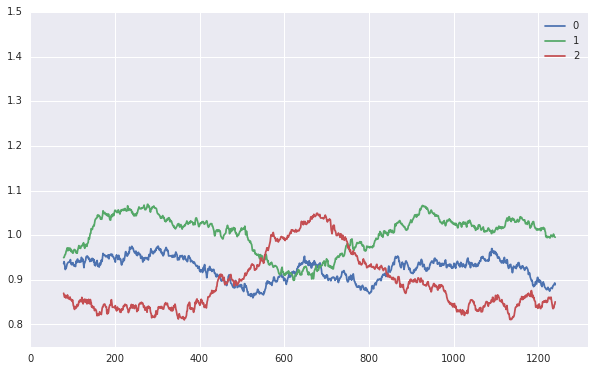

In [356]:
# unknown locus
seq = 'CGGTTCATTATTCGACGCTACACAAACTCGTGTAATGTCAGTTGGCGACCGTCAATTAGTTAAAGTTGCAGCTTGGTATGATAACGAAATGTCATATACTGCACAATTAGTTCGTACATTAGCATACTTAGCTGAACTTTCTAAATAATTTTAGTATAGTTTTTATTCAAATACGCTAGTGCTCAGAACTATTTAGCATTAATTAAAGCTTATGAGTAAGCGGGGAGCACAAACGCTTCTCCGCTTATTTTTATATAAAATTTCCTAATTACAAGGAGGAAACACCATGGCTAAAAAAATTGTTTCTGATTTAGATCTTAAAGGTAAAACAGTCCTAGTACGTGCTGATTTTAACGTACCTTTAAAAGACGGTGAAATTACTAATGACAACCGTATCGTTCAAGCTTTACCTACAATTCAATACATCATCGAACAAGGTGGTAAAATCGTACTATTTTCACATTTAGGTAAAGTGAAAGAAGAAAGTGATAAAGCAAAATTAACTTTACGTCCAGTTGCTGAAGACTTATCTAAGAAATTAGATAAAGAAGTTGTTTTCGTACCAGAAACACGCGGCGAAAAACTTGAAGCTGCTATTAAAGACCTTAAAGAAGGCGACGTATTATTAGTTGAAAATACACGTTATGAAGATTTAGACGGTAAAAAAGAATCTAAAAATGATCCAGAATTAGGTAAATACTGGGCATCTTTAGGTGATGTGTTTGTAAATGATGCTTTTGGTACTGCGCATCGTGAGCATGCATCTAATGTTGGTATTTCTACACATTTAGAAACTGCAGCTGGATTCTTAATGGATAAAGAAATTAAGTTTATTGGCGGCGTAGTTAACGATCCACATAAACCAGTTGTTGCTATTTTAGGTGGAGCAAAAGTATCTGACAAAATTAATGTCATCAAAAACTTAGTTAACATAGCTGATAAAATTATCATCGGCGGAGGTATGGCTTATACTTTCTTAAAAGCGCAAGGTAAAGAAATTGGTATTTCATTATTAGAAGAAGATAAAATCGACTTCGCAAAAGATTTATTAGAAAAACATGGTGATAAAATTGTATTACCAGTAGACACTAAAGTTGCTAAAGAATTTTCTAATGATGCCAAAATCACTGTAGTACCATCTGATTCAATTCCAGCAGACCAAGAAGGTATGGATATTGGACCAAACACTGTAAAATTATTTGCAGATGAATTAGAAGGTGCGCACACTGTTGTATGGAATGGACCTATGGGTGTATTCGAGTTCAGTAACTTTGCACAAGGTACAATTGGTGTATGTAAAGCAATTGCAAACCTTAAAGATGCAATTACGATTATCGGTGGCGGTGATTCAGCTGCAGCAGCAATCTCTTTAGGTTTTGAAAATGACTTCACTCATATTTCAACTGGTGGCGGCGCGTCATTAGAGTACCTAGAAGGTAAAGAATTGCCTGGTATCAAAGCAATCAATAATAAATAATAAAGTGATAGTTTAAAGTGATGTGGCATGTTTGTTTAACATTGTTACGGGAAAACAGTCACAAGATGACATCGTGTTTCATCACTTTTCAAAAATATTTACAAAACAAGGAGTGTCTTTAATGAGAACACCAATTATAGCTGGTAACTGGAAAATGAACAAAACAGTACAAGAAGCAAAAGACTTCGTCAATGCATTACCAACACTACCAGATTCAAAAGAAGTAGAATCAGTAATTTGTGCACCAGCAATTCAATTAGATGCATTAACTACTGCAGTTAAAGAAGGAAAAGCACAAGGTTTAGAAATCGGTGCTCAAAATACGTATTTCGAAGATAATGGTGCGTTCACAGGTGAAACGTCTCCAGTTGCATTAGCAGATTTAGGCGTTAAATACGTTGTTATCGGTCATTCTGAACGTCGTGAATTATTCCACGAAACAGATGAAGAAATTAACAAAAAAGCGCACGCTATTTTCAAACATGGAATGACTCCAATTATATGTGTTGGTGAAACAGACGAAGAGCGTGAAAGTGGTAAAGCTAACGATGTTGTAGGTGAGCAAGTTAAGAAAGCTGTTGCAGGTTTATCTGAAGATCAACTTAAATCAGTTGTAATTGCTTATGAACCAATCTGGGCAATCGGAACTGGTAAATCATCAACATCTGAAGATGCAAATGAAATGTGTGCATTTGTACGTCAAACTATTGCTGACTTATCAAGCAAAGAAGTATCAGAAGCAACTCGTATTCAATATGGTGGTAGTGTTAAACCTAACAACATTAAAGAATACATGGCACAAACTGATATTGATGGGGCATTAGTAGGTGGCGCATCACTTAAAGTTGAAGATTTCGTACAATTGTTAGAAGGTGCAAAATAATCATGGCTAAGAAACCAACTGCGTTAATTATTTTAGATGGTTTTGCGAACCGCGAAAGCGAACATGGTAATGCGGTAAAATTAGCAAACAAGCCTAATTTTGATCGTTATTACAACAAATATCCAACGACTCAAATCGAAGCGAGTGGCTTAGATGTTGGACTACCTGAAGGACAAATGGGTAACTCAGAAGTTGGTCATATGAATATCGGTGCAGGACGTATCGTTTATCAAAGTTTAACTCGAATCAATAAATCAATTGAAGACGGTGATTTCTTTGAAAATGATGTTTTAAATAATGCAATTGCACACGTGAATTCACATGATTCAGCGTTACACATCTTTGGTTTATTGTCTGACGGTGGTGTACACAGTCATTACAAACATTTATTTGCTTTGTTAGAACTTGCTAAAAAACAAGGTGTTGAAAAAGTTTACGTACACGCATTTTTAGATGGCCGTGACGTAGATCAAAAATCCGCTTTGAAATACATCGAAGAGACTGAAGCTAAATTCAATGAATTAGGCATTGGTCAATTTGCATCTGTGTCTGGTCGTTATTATGCAATGGATCGTGACAAACGTTGGGAACGTGAAGAAAAAGCTTACAATGCTATTCGTAATTTTGATGCCCCAACTTATGCAACTGCCAAAGAAGGTGTAGAAGCAAGCTATAATGAGGGCTTAACTGACGAATTCGTAGTACCATTCATCGTTGAGAATCAAAATGACGGTGTTAATGATGGAGATGCAGTGATCTTCTATAATTTCCGACCTGATAGAGCAGCGCAATTATCGGAAATTTTTGCGAACAGAGCATTCGAAGGCTTTAAAGTTGAACAAGTTAAAGACTTATTCTATGCAACATTCACTAAGTATAATGACAATATCGATGCGGCTATCGTCTTCGAAAAAGTTGATTTAAATAATACAATTGGTGAAATTGCACAAAATAACAATTTAACTCAATTACGTATTGCAGAAACTGAAAAATACCCTCACGTTACTTACTTTATGAGTGGTGGACGTAACGAGGAATTTAAAGGTGAACGCCGTCGTTTAATTGATTCACCTAAAGTTGCAACGTATGACTTGAAACCAGAAATGAGTGCTTATGAAGTTAAAGATGCATTATTAGAAGAGTTAAATAAAGGTGACTTGGACTTAATTATTTTAAACTTTGCTAACCCTGATATGGTTGGACATAGTGGTATGCTTGAGCCGACAATCAAAGCAATCGAAGCGGTTGATGAATGTTTAGGAGAAGTGGTTGATAAGATTTTAGACATGGACGGTTATGCAATTATTACTGCTGACCATGGTAACTCTGATCAAGTATTGACGGATGATGATCAACCAATGACTACGCATACAACGAACCCAGTACCAGTGATTGTAACAAAAGAAGGCGTTACACTTAGAGAAACTGGTCGCTTAGGTGACTTAGCACCTACATTATTAGATTTATTAAATGTAGAACAACCTGAAGATATGACAGGTGAATCTTTAATTAAACACTAATATTGTAAAAGATGTTAAGTAAACGCTTAATGACACTTATTTTTTGAAAATAATAGTAATATCATTTTGTTAAATGAAAG'

scores = codonPrefs(seq,round(len(seq)/25))
scores.plot(kind='line',subplots=False,figsize=(10,6),ylim=[.75,1.5])

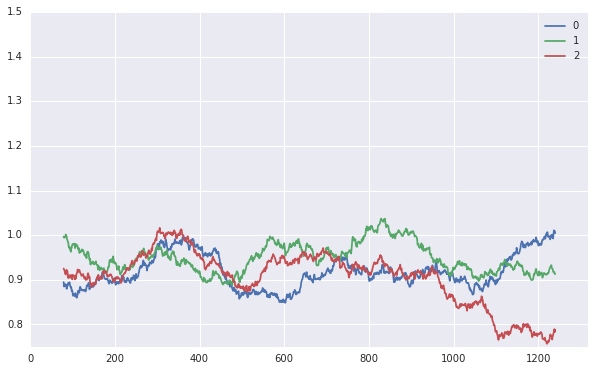

In [357]:
# unknown locus
seq = 'GGTCCAATTTCAAAATCAGGTGTAAATCACCGATTAAGAAAACTGAATGATTTAGCCGATAAGATTAGAAATGGTGAACAAATAGAATTATAAGTAAGAAGGTGTTTTTGGTAGTGAATTATCAAAAACACTTTTTTATGATTAAAAAGTGTTTAATGAATAATAGTCGACTAACTATTAAATTGAGCTGGAAAGTTTAATGAAGGAAATTCAATAACCAAGTGATGCCTAATTTTCTCATTAAATAGCATCATATGTATCAATTTGGTCATAAGAAAATATGAATGTGATAATTAATTGAGTCCCTGAAAGTCCCTGATCATAGACAAAAACAAAATCAGCATAAATAAGAATCCCGACATTGCGGGATTCTCTGTATTGAAAAGTATTGTATTTTATTAAAACAGCCTCCTTGAAGGGAATTGAACCCCTATCTTAAGAACCGGAATCTTACGTGTTATCCATTACACCACAAGGAGCAAATATGTAATCATATCTCTGTACTATGAGAAGTAAAATAAGTACAATCTAAAATAGATATTATCAGTTTACAAAGGAAAGAGAAAAGCGTCAAACAATGTAACTATTTAAAGTCAAAGTGTTTGACCAAATTTGACTTAATATGTAAAATAATGAGTAACAGTTATTACAAGGAGGAAATATAGATGAATTTAATTCCTACAGTTATTGAAACAACAAACCGCGGTGAACGTGCATATGATATATACTCACGTTTATTAAAAGACCGTATTATTATGTTAGGTTCACAAATTGATGACAACGTAGCAAATTCAATCGTATCACAGTTATTATTCTTACAAGCGCAAGACTCAGAGAAAGATATTTATTTATACATTAATTCACCAGGTGGAAGTGTAACAGCTGGTTTTGCGATTTATGATACAATTCAACACATTAAACCTGATGTTCAAACAATTTGTATCGGTATGGCTGCATCAATGGGATCATTCTTATTAGCAGCTGGTGCAAAAGGTAAACGTTTCGCGTTACCAAATGCAGAAGTAATGATTCACCAACCATTAGGTGGTGCTCAAGGACAAGCAACTGAAATCGAAATTGCTGCAAATCACATTTTAAAAACACGTGAAAAATTAAACCGCATTTTATCAGAGCGTACTGGTCAAAGTATTGAAAAAATACAAAAAGACACAGATCGTGATAACTTCTTAACTGCAGAAGAAGCTAAAGAATATGGCTTAATTGATGAAGTGATGGTACCTGAAACAAAATAATTCAAAGTAAAGAGTAGACTAAGCTGTCTGCTCTTTTTGTATGAGTAAACCAAGGTGTCAATAATTTGTTTACTATACTTTGAGCGGAAATATGATTGAATGAAGCTAGTTGAACCGTAACTATATGAAATGTTCCCTTCAAAGTAGACATTGAAAGGAACATTTCAATCCTTTGTTTGTAAGTCGCTCTAGACATTACATTTAGTACATATGTTGTTTCTAATGCTCATTAATGGTATTGATTATTCTTTAATTAAATCTTCAAGTGCCATTTTTAAATTACTATATTTAAATTGGAATCCCAATGCTTGAATTTTATTAGGTAATACTTTTTGAGTATCCAATACTACTGTTGACATTTGACCAAGTATGAGACGCATTGCAAGACTTGGTGCCCAAGTTTCATGAGGCTTATGCATAGCTCTTGCTAAAGTGTAGCCAAATAAATTTTGACGTTCAGGTATAGGTGCAGTTAAATTAAACGGACCACTAGCTGACTCGTTATTTATTAAAAATAAAATAGCTTGAATTAAATCATTGATATGAATCCATGAATACCATTGTTGACCAGAACCTAATTTACCACCAATGTAATATTCGTATGGTAGTTTCATTGTTTGTAACGCACCGCCTTCATTCGATAAAATTATACCGAAACGACCGATGACAACTCGTGTACCTAATTGTTCAAATTGTTGTGCGAAACGTTCCCATTGATACACAATATCTGATAAGAAATCAAAAGGTAAAGTTTTATAAACTTCTGTGTAACTCATAAATAAATCAGGAGGATAGTAACCAGTGGCACTAGCATTAAATAAAGCTTTAGGTGCTTTATTACGTGATTTAAACAATTCATATAAAGCTTGCGTAGATTGAATTCTACTTAGCATTAGCGTTTGTTTATATTCCGGTGTCCATCGTTTATTCAATGTAGCACCTGCTAAGTTGATGACCACATCGATATTTTGAGGAACTTTGTGTTCCCACCCAGATTTAGCCCAGTTGACATATGAAATTTTCTTATCATTTGAAATTTGGTCGTGTCGCGTTAATATCGTGATATGTGAATCTGATTTTTTAATTTCATTAACTAATTGAGATCCAACCATACCAGTCCCACCAGTAATTAAGTATTGTTTCATTATCATTCACCCCATGTAATTTTGTATTTAGTTACTATTTAATAATCATTATTGTTGTTCAAAGGTTATACATTATTTAGACAATAATATGTCAATAACTTTTTTTGAATTGTATTTTAATAAAAATGATATAAGTTATAATAAAGGTGTACCTTCGATAACGAATAAACATCTCTTAAAAGTATGTGTAAAACGCTGCATGATACAAACGAAGGTAAAAATTTGACTCCCTTTAGTAGTGGACCCGTACGTTAATCGTGCGGGTCGTTTTTATTTATTTCTTATTCCCATTATACATCAATTTAAAGCATTAATTTTTTAAACAAATTTAAGAATACATAGTAATATAACAATCTAAACATAAAAACTTTTAACACAACACTTAAACCAATGCTTTAATTTTCAATACGTAGCTATAATTTGTTGTAAAATCAAAAAGGTTAAAATGTTAATTTTCAAAAAAAGGCTCAAAATATGTTTGATTTAGTTATTAAATGTTAAGATATATAAGACTACTATTTCTTTGTAAAAATGAATCCGATTTACGAGTGAGTAATAGTGAAGGCAGTTTTAAGTTGAAGAAGGCAAAAAGAGTAAATGTTTATTAATATTTGTAGAAACTAGGTAAGCAAATTAGTTGTGAAAATGTTAATGGTTGCGTGATAATTTCTATATTTAAATTAGTTTGAAGTGAGGGAGAGTATGTCGAATCAAAATTACGACTACAATAAAAATGAAGATGGAAGTAAGAAGAAAATGAGTACAACAGCGAAAGTAGTTAGCATTGCGACGGTATTGCTATTACTCGGAGGATTAGTATTTGCAATTTTTGCATATGTAGATCATTCGAATAAAGCTAAAGAACGTATGTTGAACGAACAAAAGCAGGAACAAAAAGAAAAGCGTCAAAAAGAAAATGCAGAAAAAGAGAGAAAGAAAAAGCAACAAGAGGAAAAAGAGCAGAATGAGCTAGATTCACAAGCAAACCAATATCAGCAATTGCCACAGCAGAATCAATATCAATATGTGCCACCTCAGCAACAAGCACCTACAAAGCAACGTCCTGCTAAAGAAGAGAATGATGATAAAGCATCAAAGGATGAGTCGAAAGATAAGGATGACAAAGCATCTCAAGATAAATCAGATGATAATCAGAAGAAAACTGATGATAATAAACAACCAGCTCAGCCTAAACCACAGCCGCAACAACCAACACCAAAGCCAAATAATAATCAACAAAACAATCAATCAAATCAGCAAGCAAAACCACAAGCACCACAACAAAATAGCCAATCAACAACAAATAAACAAAATAATGCTAATGATAAGTAGTATTTAGTCAAACAAAAATGAACCAGTATGACAGACAACACAATTAATTAGGTTGTCTCGAATATTGGTTCTTATTTTTATAATTGTTAATTAGGGGAGAGATGATACTTAAATAGTTAGTTGTTTATTTTACGGATAGTGAAATTTATTTTGAGTGAGGTGGGACAGAAATGATATTTTTGCAAAATTTATTTCGTCGTCCCACCCCAACTCGCATTGCCTGTAGAATT'

scores = codonPrefs(seq,round(len(seq)/25))
scores.plot(kind='line',subplots=False,figsize=(10,6),ylim=[.75,1.5])

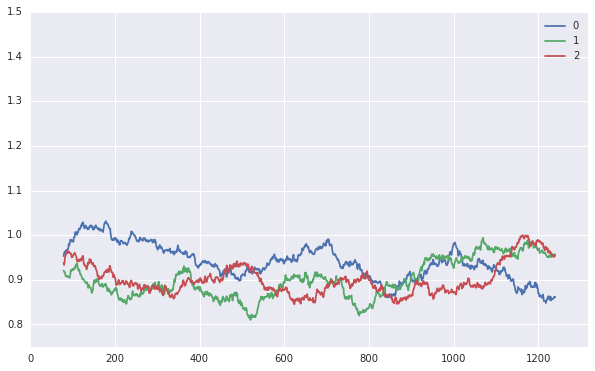

In [358]:
# unknown locus
seq = 'AGAAGGTAAGGACTTTTATATGTTTTGCACCTCATACAGTTAAAGAAGAATATGGTGTGACATTAGACGATATCGATTTAGAAAAATATTATGATGACATGGTTGCAAACCCAAATGTTGAGAAAAAGAAAAAGAATGCGCGTGAAATGTTGAATTTAATTGCGCAAACACAATTACAAATCAGGTTATCCATATTTAATGTTTAAAGATAATGCTAACAGAGTGCATCCGAATTCAAACATTGGACAAATTAAAATGAGTAACTTATGTACGGAAATTTTCCAACTACAAGAAACTTCAATTATTAATGACTATGGTATTGAAGACGAAATTAAACGTGATATTTCTTGTAACTTGGGCTCATTAAATATTGTTAATGTAATGGAAAGCGGAAAATTCAGAGATTCAGTTCACTCTGGTATGGACGCATTAACTGTTGTGAGTGATGTAGCAAATATTCAAAATGCACCAGGAGTTAGAAAAGCTAACAGTGAATTACATTCAGTTGGTCTTGGTGTGATGAATTTACACGGTTACCTAGCAAAAAATAAAATTGGTTATGAGTCAGAAGAAGCAAAAGATTTTGCAAATATCTTCTTTATGATGATGAATTTCTACTCAATCGAACGTTCAATGGAAATCGCTAAAGAGCGTGGTATCAAATATCAAGACTTTGAAAAGTCTGATTATGCTAATGGCAAATATTTCGAGTTCTATACAACTCAAGAATTTGAACCTCAATTCGAAAAAGTACGTGAATTATTCGATGGTATGGCTATTCCTACTTCTGAGGATTGGAAGAAACTACAACAAGATGTTGAACAATATGGTTTATATCATGCATATAGATTAGCAATTGCTCCAACACAAAGTATTTCTTATGTTCAAAATGCAACAAGTTCTGTAATGCCAATCGTTGACCAAATTGAACGTCGTACTTATGGTAATGCGGAAACATTTTACCCTATGCCATTCTTATCACCACAAACAATGTGGTACTACAAATCAGCATTCAATACTGATCAGATGAAATTAATCGATTTAATTGCGACAATTCAAACGCATATTGACCAAGGTATCTCAACGATCCTTTATGTTAATTCTGAAATTTCTACACGTGAGTTAGCAAGATTATATGTATATGCGCACTATAAAGGATTAAAATCACTTTACTATACTAGAAATAAATTATTAAGTGTAGAAGAATGTACAAGTTGTTCTATCTAACAATTAAATGTTGAAAATGACAAACAGCTAATCATCTGGTCTGAATTAGCAGATGATTAGACTGCTATGTCTGTATTTGTCAATTATTGAGTAACATTACAGGAGGAAATTATATTCATGATAGCTGTTAATTGGAACACACAAGAAGATATGACGAATATGTTTTGGAGACAAAATATATCTCAAATGTGGGTTGAAACAGAATTTAAAGTATCAAAAGACATTGCAAGTTGGAAGACTTTATCTGAAGCTGAACAAGACACATTTAAAAAAGCATTAGCTGGTTTAACAGGCTTAGATACACATCAAGCAGATGATGGCATGCCTTTAGTTATGCTACATACGACTGACTTAAGGAAAAAAGCAGTTTATTCATTTATGGCGATGATGGAGCAAATACACGCGAAAAGCTATTCACATATTTTCACAACACTATTACCATCTAGTGAAACAAACTACCTATTAGATGAATGGGTTTTAGAGGAACCCCATTTAAAATATAAATCTGATAAAATTGTTGCTAATTATCACAAACTTTGGGGTAAAGAAGCTTCGATATACGACCAATATATGGCCAGAGTTACGAGTGTATTTTTAGAAACATTCTTATTCTTCTCAGGTTTCTATTATCCACTATATCTTGCTGGTCAAGGGAAAATGACGACATCAGGTGAAATCATTCGTAAAATTCTTTTAGATGAATCTATTCATGGTGTATTTACCGGTTTAGATGCACAGCATTTACGAAATGAACTATCTGAAAGTGAGAAACAAAAAGCAGATCAAGAAATGTATAAATTGCTAAATGACTTGTATTTAAATGAAGAGTCATACACAAAAATGTTATACGATGATCTTGGAATCACTGAAGATGTGCTAAACTATGTTAAATATAATGGAAACAAAGCACTTTCAAACTTAGGCTTTGAACCTTATTTTGAGGAACGTGAATTTAACCCAATCATTGAGAATGCCTTAGATACAACAACTAAAAACCATGACTTCTTCTCAGTAAAAGGTGATGGTTATGTATTAGCATTAAACGTAGAAGCATTACAAGATGATGACTTTGTATTTGACAACAAATAACAATTAAATTAAAAGACCTTCACATGTAAAGGGAAATAGCGATTCGTTTCGTCTTGTCTCCTACATGTTGAAGGTCTTTTTTTATGTGTATCTAACTCATTATGAGTCTGAGTAAGAAATCAATGCTCTAAGATGTACAATGCTATTTATATTGGCAGTAGTTGGCGGGGCCCCAACACAGAAGCAGGCGGAAAGTCAGCTAACAATATTGTGCAAGTTGGCGGGGCCCCAACATAGAAGCAGGCGGAAAGTCAGCTAACAATAATGTGCAAGTTGGCGGGGCCCCAACATAAAAGCAGGCGGAAAGTCAGCTAACAATATTGTGCAAGTTCGGGCGGGGCCCCAACATAAAGAAAAACTTTTTCCTTTAGAAATTATCACTTCCACATGAGTTTTACTCATGTATTCCTATTTTTAAGTACACATTAGCTGAGGCTAATGTTAAGAACCACTACTTAATCAATCATTAGTAGTTTTTATCATTTCCACTATTCCCAGACATCAAAATCTTAAGTGTTCTATTTTACTTTAAGTAAACAAAATACACATTCCGAAAAATTAAATTTCAGTTTAATTGCAAATATCAATAAAATTGACACTAAATTATTTGAAAGGCTATTGAAATTATGGTCAAAAAACGCTACTATTAATGAGAAATATTATCAATGATAATGATTATCATTAATTTAAAGGGAGAAAAATTTGTAATGAAGTATTTATTAAAGGGAAATATTTTGCTTCTATTACTAATATTGTTGACAATTATTTCGTTGTTCATAGGTGTGAGTGAACTATCAATTAAAGATTTACTACATTTAACTGAGTCACAGCGGAATATTTTATTCTCAAGCCGAATACCAAGGACGATGAGTATTTTAATTGCTGGAAGTTCGTTGGCTTTAGCAGGCTTGATAATGCAACAAATGATGCAAAATAAGTTTGTTAGTCCGACTACAGCTGGAACGATGGAATGGGCTAAACTAGGTATTTTAATTGCTTTATTGTTCTTTCCAACCGGTCATATTTTATTAAAACTAGTATTTGCTGTTATTTGCAGTATTTGCGGTACGTTTTTATTTGTTAAAATCATTGATTTTATAAAAGTGAAAGATGTCATTTTTGTACCGCTTTTAGGAATTATGATGGGTGGGATTGTTGCAAGTTTCACAACCTTCATCTCATTGCGCACGAATGCTGTTCAAAGCATTGGTAACTGGCTTAACGGGAACTTTGCCATTATCACAAGTGGACGCTATGAAATTTTATATTTAAGTATTCCTCTTTTAGCATTGACATATCTTTTTGCTAATCATTTCACGATTGTAGGAATGGGTAAAGACTTTACTAATAATTTAGGTTTGAGTTACGAAAAATTAATTAACATCGCATTGTTTATTACTGCAACTATTACAGCATTGGTAGTGGTGACTGTTGGAACATTACCGTTCTTAGGACTAGTAATACCAAATATTATTTCAATTTATCGAGGTGATCATTTGAAAAATGCTATCCCTCATACGATGATGTTAGGTGCCATCTTTGTATTATTTTCTGATATAGTTGGCAGAATTGTTGTTTATCCATATGAAATAAATATTGGTTTAACAATAGGTGTATTTGGAACAATCATTTTCCTTATCTTGC'

scores = codonPrefs(seq,round(len(seq)/25))
scores.plot(kind='line',subplots=False,figsize=(10,6),ylim=[.75,1.5])

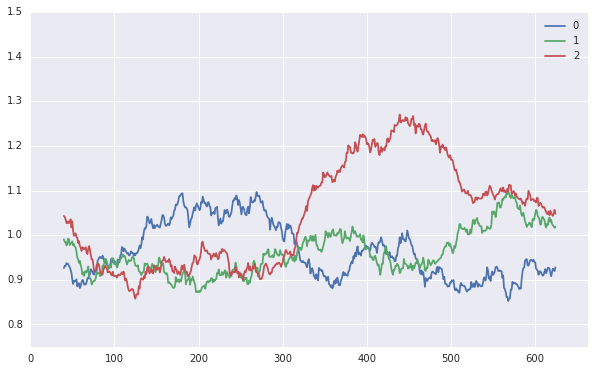

In [359]:
# triose phosphate isomerase (tria or something)
seq = 'ATCATCAGAAATGCCCATGCGCCGGAACGCCCGCGATCATGCAAGCGCTTAACAGTTACTGCCGCTGTTGGCCAGAGCAAGCACACAAGGCAAAACGCCGCGGTCTGAATATCGAGTAGATTCTTACCCGCCAGTGAGAAAAGCACCAGCATGCCTGCGAACCACAGGCCTATCCAAATCCAGAAATCACGGCGTCCAATACGCCCTTTAAATGAGAATAACCATTGCTGTATGGTCATGTAAGTTCCTTGATGGTTGTCTTTTCCAGGATTCTACCCTTTTGACAAGGGCGACAGATATCGTTTTAATCGGAGCCAGTCATAACAAAAGGTACTGTCAATGAAGCCAGGGTGTACGCTGTTTTTTCTCTTATGTTCTGCATTAACCGTTACAACAGAGGCGCATGCACAAACACCAGATACGGCAACGACCGCGCCTTATCTGCTGGCTGGAGCCCCTACTTTCGATCTCTCCATCAGCCAGTTTCGAGAAGACTTTAACAGCCAGAATCCCAGCCTGCCACTGAACGAATTTCGTGCCATCGACAGCAGTCCCGACAAAGCCAATCTCACTCGTGCTGCAAGTAAAATTAATGAGAACTTGTATGCTTCTACAGCGCTGGAGCGCGGTACCTTAAAAATCAAAAGCATTCAAATGACCTGGCTACCCATCCAGGGGCCAGAGCAAAAAGCCGCGAAAGCGAAAGCTCAGGAATACATGGCAGCGGTGATCCGCACACTCACCCCATTAATGACCAAAACACAAAGCCAGAAAAAACTGCAGTCGCTACTAACGGCGGGGAAAAACAAACGTTATTACACCGAGACAGAAGGTGCACTGCGTTATGTTGTCGCGGACAACGGCGAAAAGGGGCTGACCTTCGCTGTTGAACCGATTAAGCTGGCGCTATCTGAATCGCTTGAAGGTTTGAATAAATGACAAAAAGCAAAGCCTTTGTGCCGATGAATCTCTATACTGTTTCACAGACCTGCTGCCCTGCGGGGCGGCCATCTTCCTTTATTCGCTTATAAGCGTGGAGAATTAAAATGCGACATCCTTTAGTGATGGGTAACTGGAAACTGAACGGCAGCCGCCACATGGTTCACGAGCTGGTTTCTAACCTGCGTAAAGAGCTGGCAGGTGTTGCTGGCTGTGCGGTTGCAATCGCACCACCGGAAATGTATATCGATATGGCGAAGCGCGAAGCTGAAGGCAGCCACATCATGCTGGGTGCGCAAAACGTGGACCTGAACCTGTCCGGCGCATTCACCGGTGAAACCTCTGCTGCTATGCTGAAAGACATCGGCGCACAGTACATCATCATCGGTCACTCTGAACGTCGTACTTACCACAAAGAATCTGACGAACTGATCGCGAAAAAATTCGCGGTGCTGAAAGAGCAGGGCCTGACTCCGGTTCTGTGCATCGGTGAAACCGAAGCTGAAAATGAAGCGGGCAAAACTGAAGAAGTTTGCGCACGTCAGATCGACGCGGTACTGAAAACTCAGGGTGCTGCGGCATTCGAAGGTGCGGTTATCGCTTACGAACCTGTATGGGCAATCGGTACTGGCAAATCTGCAACTCCGGCTCAGGCACAGGCTGTTCACAAATTCATCCGTGACCACATCGCTAAAGTTGACGCTAACATCGCTGAACAAGTGATCATTCAGTACGGCGGCTCTGTAAACGCGTCTAACGCTGCAGAACTGTTTGCTCAGCCGGATATCGACGGCGCGCTGGTTGGTGGTGCTTCTCTGAAAGCTGACGCCTTCGCAGTAATCGTTAAAGCTGCAGAAGCGGCTAAACAGGCTTAAGTCTGACAGGTGCCGGATTTCATATCCGGCACTTACTTTCCTTAACTCTTCGCCTTAACGCAAAATCTCACACTGATGATCCTGAATTTCCTCGGCTGAAGCACGGTTAAGCGTCAGTAGATTTCGTTGTGTCGCCAGCAATACAAATGAGTTATCACTCTGCCGTACCATCGCCAGCCCGT'

scores = codonPrefs(seq,round(len(seq)/25))
scores.plot(kind='line',subplots=False,figsize=(10,6),ylim=[.75,1.5])

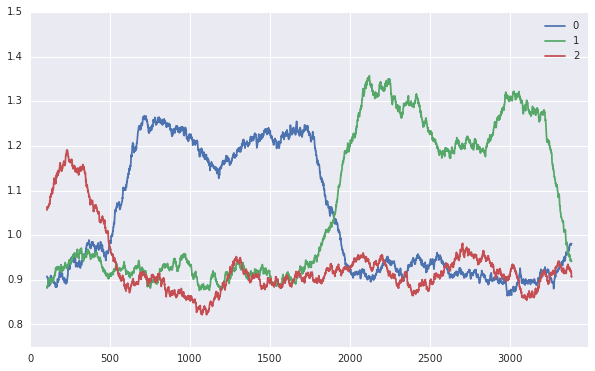

In [360]:
# rpoB/C
seq = 'ACGTATATCCGAGATATTCGGGTTGTGGCAAGGCGGCAACTGAGTGAGTCGCCAGGAGCATAGCTAACTATGTGACTGGTGCGAATGAAGGAAGCCAACGCCGTCACAAGCTGAATAGCGACGGATAGAAAAGATTTGTTCGTTGGAGCCTGGCCTATCCAGGCCTCCGTCGAAGACCGCAGGAGTTTCGCAAGAAACTTAATCCCCTGCGTAGACGGTGACAGAACGCTAAGATTATTCTTTTATATTCTGGCTTGTTTCTGCTCACCGTAATTAAGACGCTCTCTCCGTTTGGAGGAGTGAAGTGAGTTCCAGAGATTTTCTCTGGCAAACATCCAGGAGCAAAGCTAATGGCTTTAAATCTTCAAGACAAACAAGCGATTGTTGCTGAAGTCAGCGAAGTAGCCAAAGGCGCGCTGTCTGCAGTAGTTGCGGATTCCCGTGGCGTAACTGTAGATAAAATGACTGAACTGCGTAAAGCAGGTCGCGAAGCTGGCGTATACATGCGTGTTGTTCGTAACACCCTGCTGCGCCGTGCTGTTGAAGGTACTCCGTTCGAGTGCCTGAAAGACGCGTTTGTTGGTCCGACCCTGATTGCATACTCTATGGAACACCCGGGCGCTGCTGCTCGTCTGTTCAAAGAGTTCGCGAAAGCGAATGCAAAATTTGAGGTCAAAGCCGCTGCCTTTGAAGGTGAGCTGATCCCGGCGTCTCAGATCGACCGCCTGGCAACTCTGCCGACCTACGAAGAAGCAATTGCACGCCTGATGGCAACCATGAAAGAAGCTTCGGCTGGCAAACTGGTTCGTACTCTGGCTGCTGTACGCGATGCGAAAGAAGCTGCTTAATCGCAGTTATCTTTTTAACGCATTCGCTTACGTATAAACTTATTCTGATATTCAGGAACAATTTAAATGTCTATCACTAAAGATCAAATCATTGAAGCAGTTGCAGCTATGTCTGTAATGGACGTTGTAGAACTGATCTCTGCAATGGAAGAAAAATTCGGTGTTTCCGCTGCTGCTGCTGTAGCTGTAGCTGCTGGCCCGGTTGAAGCTGCTGAAGAAAAAACTGAATTCGACGTAATTCTGAAAGCTGCTGGCGCTAACAAAGTTGCTGTTATCAAAGCAGTACGTGGCGCAACTGGCCTGGGTCTGAAAGAAGCTAAAGACCTGGTAGAATCTGCACCGGCTGCTCTGAAAGAAGGCGTGAGCAAAGACGACGCAGAAGCACTGAAAAAAGCTCTGGAAGAAGCTGGCGCTGAAGTTGAAGTTAAATAAGCCAACCCTTCCGGTTGCAGCCTGAGAAATCAGGCTGATGGCTGGTGACTTTTTAGTCACCAGCCTTTTTGCGCTGTAAGGCGCCAGTAGCGTTTCACACTGTTTGACTACTGCTGTGCCTTTCAATGCTTGTTTCTATCGACGACTTAATATACTGCGACAGGACGTCCGTTCTGTGTAAATCGCAATGAAATGGTTTAAGCGTGATAGCAACAGGCATTGCGGAAAGTGTTCCATTTTCCGGTCAACAAAATAGTGTTGCACAAACTGTCCGCTCAATGGACAGATGGGTCGACTTGTCAGCGAGCTGAGGAACCCTATGGTTTACTCCTATACCGAGAAAAAACGTATTCGTAAGGATTTTGGTAAACGTCCACAAGTTCTGGATGTACCTTATCTCCTTTCTATCCAGCTTGACTCGTTTCAGAAATTTATCGAGCAAGATCCTGAAGGGCAGTATGGTCTGGAAGCTGCTTTCCGTTCCGTATTCCCGATTCAGAGCTACAGCGGTAATTCCGAGCTGCAATACGTCAGCTACCGCCTTGGCGAACCGGTGTTTGACGTCCAGGAATGTCAAATCCGTGGCGTGACCTATTCCGCACCGCTGCGCGTTAAACTGCGTCTGGTGATCTATGAGCGCGAAGCGCCGGAAGGCACCGTAAAAGACATTAAAGAACAAGAAGTCTACATGGGCGAAATTCCGCTCATGACAGACAACGGTACCTTTGTTATCAACGGTACTGAGCGTGTTATCGTTTCCCAGCTGCACCGTAGTCCGGGCGTCTTCTTTGACTCCGACAAAGGTAAAACCCACTCTTCGGGTAAAGTGCTGTATAACGCGCGTATCATCCCTTACCGTGGTTCCTGGCTGGACTTCGAATTCGATCCGAAGGACAACCTGTTCGTACGTATCGACCGTCGCCGTAAACTGCCTGCGACCATCATTCTGCGCGCCCTGAACTACACCACAGAGCAGATCCTCGACCTGTTCTTTGAAAAAGTTATCTTTGAAATCCGTGATAACAAGCTGCAGATGGAACTGGTGCCGGAACGCCTGCGTGGTGAAACCGCATCTTTTGACATCGAAGCTAACGGTAAAGTGTACGTAGAAAAAGGCCGCCGTATCACTGCGCGCCACATTCGCCAGCTGGAAAAAGACGACGTCAAACTGATCGAAGTCCCGGTTGAGTACATCGCAGGTAAAGTGGTTGCTAAAGACTATATTGATGAGTCTACCGGCGAGCTGATCTGCGCAGCGAACATGGAGCTGAGCCTGGATCTGCTGGCTAAGCTGAGCCAGTCTGGTCACAAGCGTATCGAAACGCTGTTCACCAACGATCTGGATCACGGCCCATATATCTCTGAAACCTTACGTGTCGACCCAACTAACGACCGTCTGAGCGCACTGGTAGAAATCTACCGCATGATGCGCCCTGGCGAGCCGCCGACTCGTGAAGCAGCTGAAAGCCTGTTCGAGAACCTGTTCTTCTCCGAAGACCGTTATGACTTGTCTGCGGTTGGTCGTATGAAGTTCAACCGTTCTCTGCTGCGCGAAGAAATCGAAGGTTCCGGTATCCTGAGCAAAGACGACATCATTGATGTTATGAAAAAGCTCATCGATATCCGTAACGGTAAAGGCGAAGTCGATGATATCGACCACCTCGGCAACCGTCGTATCCGTTCCGTTGGCGAAATGGCGGAAAACCAGTTCCGCGTTGGCCTGGTACGTGTAGAGCGTGCGGTGAAAGAGCGTCTGTCTCTGGGCGATCTGGATACCCTGATGCCACAGGATATGATCAACGCCAAGCCGATTTCCGCAGCAGTGAAAGAGTTCTTCGGTTCCAGCCAGCTGTCTCAGTTTATGGACCAGAACAACCCGCTGTCTGAGATTACGCACAAACGTCGTATCTCCGCACTCGGCCCAGGCGGTCTGACCCGTGAACGTGCAGGCTTCGAAGTTCGAGACGTACACCCGACTCACTACGGTCGCGTATGTCCAATCGAAACCCCTGAAGGTCCGAACATCGGTCTGATCAACTCTCTGTCCGTGTACGCACAGACTAACGAATACGGCTTCCTTGAGACTCCGTATCGTAAAGTGACCGACGGTGTTGTAACTGACGAAATTCACTACCTGTCTGCTATCGAAGAAGGCAACTACGTTATCGCCCAGGCGAACTCCAACTTGGATGAAGAAGGCCACTTCGTAGAAGACCTGGTAACTTGCCGTAGCAAAGGCGAATCCAGCTTGTTCAGCCGCGACCAGGTTGACTACATGGACGTATCCACCCAGCAGGTGGTATCCGTCGGTGCGTCCCTGATCCCGTTCCTGGAACACGATGACGCCAACCGTGCATTGATGGGTGCGAACATGCAACGTCAGGCCGTTCCGACTCTGCGCGCTGATAAGCCGCTGGTTGGTACTGGTATGGAACGTGCTGTTGCCGTTGACTCCGGTGTAACTGCGGTAGCTAAACGTGGTGGTGTCGTTCAGTACGTGGATGCTTCCCGTATCGTTATCAAAGTTAACGAAGACGAGATGTATCCGGGTGAAGCAGGTATCGACATCTACAACCTGACCAAATACACCCGTTCTAACCAGAACACCTGTATCAACCAGATGCCGTGTGTGTCTCTGGGTGAACCGGTTGAACGTGGCGACGTGCTGGCAGACGGTCCGTCCACCGACCTCGGTGAACTGGCGCTTGGTCAGAACATGCGCGTAGCGTTCATGCCGTGGAATGGTTACAACTTCGAAGACTCCATCCTCGTATCCGAGCGTGTTGTTCAGGAAGACCGTTTCACCACCATCCACATTCAGGAACTGGCGTGTGTGTCCCGTGACACCAAGCTGGGTCCGGAAGAGATCACCGCTGACATCCCGAACGTGGGTGAAGCTGCGCTCTCCAAACTGGATGAATCCGGTATCGTTTACATTGGTGCGGAAGTGACCGGTGGCGACATTCTGGTTGGTAAGGTAACGCCGAAAGGTGAAACTCAGCTGACCCCAGAAGAAAAACTGCTGCGTGCGATCTTCGGTGAGAAAGCCTCTGACGTTAAAGACTCTTCTCTGCGCGTACCAAACGGTGTATCCGGTACGGTTATCGACGTTCAGGTCTTTACTCGCGATGGCGTAGAAAAAGACAAACGTGCGCTGGAAATCGAAGAAATGCAGCTCAAACAGGCGAAGAAAGACCTGTCTGAAGAACTGCAGATCCTCGAAGCGGGTCTGTTCAGCCGTATCCGTGCTGTGCTGGTAGCCGGTGGCGTTGAAGCTGAGAAGCTCGACAAACTGCCGCGCGATCGCTGGCTGGAGCTGGGCCTGACAGACGAAGAGAAACAAAATCAGCTGGAACAGCTGGCTGAGCAGTATGACGAACTGAAACACGAGTTCGAGAAGAAACTCGAAGCGAAACGCCGCAAAATCACCCAGGGCGACGATCTGGCACCGGGCGTGCTGAAGATTGTTAAGGTATATCTGGCGGTTAAACGCCGTATCCAGCCTGGTGACAAGATGGCAGGTCGTCACGGTAACAAGGGTGTAATTTCTAAGATCAACCCGATCGAAGATATGCCTTACGATGAAAACGGTACGCCGGTAGACATCGTACTGAACCCGCTGGGCGTACCGTCTCGTATGAACATCGGTCAGATCCTCGAAACCCACCTGGGTATGGCTGCGAAAGGTATCGGCGACAAGATCAACGCCATGCTGAAACAGCAGCAAGAAGTCGCGAAACTGCGCGAATTCATCCAGCGTGCGTACGATCTGGGCGCTGACGTTCGTCAGAAAGTTGACCTGAGTACCTTCAGCGATGAAGAAGTTATGCGTCTGGCTGAAAACCTGCGCAAAGGTATGCCAATCGCAACGCCGGTGTTCGACGGTGCGAAAGAAGCAGAAATTAAAGAGCTGCTGAAACTTGGCGACCTGCCGACTTCCGGTCAGATCCGCCTGTACGATGGTCGCACTGGTGAACAGTTCGAGCGTCCGGTAACCGTTGGTTACATGTACATGCTGAAACTGAACCACCTGGTCGACGACAAGATGCACGCGCGTTCCACCGGTTCTTACAGCCTGGTTACTCAGCAGCCGCTGGGTGGTAAGGCACAGTTCGGTGGTCAGCGTTTCGGGGAGATGGAAGTGTGGGCGCTGGAAGCATACGGCGCAGCATACACCCTGCAGGAAATGCTCACCGTTAAGTCTGATGACGTGAACGGTCGTACCAAGATGTATAAAAACATCGTGGACGGCAACCATCAGATGGAGCCGGGCATGCCAGAATCCTTCAACGTATTGTTGAAAGAGATTCGTTCGCTGGGTATCAACATCGAACTGGAAGACGAGTAATTCTCGCTCAAACAGGTCACTGCTGTCGGGTTAAAACCCGGCAGCGGATTGTGCTAACTCCGACGGGAGCAAATCCGTGAAAGATTTATTAAAGTTTCTGAAAGCGCAGACTAAAACCGAAGAGTTTGATGCGATCAAAATTGCTCTGGCTTCGCCAGACATGATCCGTTCATGGTCTTTCGGTGAAGTTAAAAAGCCGGAAACCATCAACTACCGTACGTTCAAACCAGAACGTGACGGCCTTTTCTGCGCCCGTATCTTTGGGCCGGTAAAAGATTACGAGTGCCTGTGCGGTAAGTACAAGCGCCTGAAACACCGTGGCGTCATCTGTGAGAAGTGCGGCGTTGAAGTGACCCAGACTAAAGTACGCCGTGAGCGTATGGGCCACATCGAACTGGCTTCCCCGACTGCGCACATCTGGTTCCTGAAATCGCTGCCGTCCCGTATCGGTCTGCTGCTCGATATGCCGCTGCGCGATATCGAACGCGTACTGTACTTTGAATCCTATGTGGTTATCGAAGGCGGTATGACCAACCTGGAACGTCAGCAGATCCTGACTGAAGAGCAGTATCTGGACGCGCTGGAAGAGTTCGGTGACGAATTCGACGCGAAGATGGGGGCGGAAGCAATCCAGGCTCTGCTGAAGAGCATGGATCTGGAGCAAGAGTGCGAACAGCTGCGTGAAGAGCTGAACGAAACCAACTCCGAAACCAAGCGTAAAAAGCTGACCAAGCGTATCAAACTGCTGGAAGCGTTCGTTCAGTCTGGTAACAAACCAGAGTGGATGATCCTGACCGTTCTGCCGGTACTGCCGCCAGATCTGCGTCCGCTGGTTCCGCTGGATGGTGGTCGTTTCGCGACTTCTGACCTGAACGATCTGTATCGTCGCGTCATTAACCGTAACAACCGTCTGAAACGTCTGCTGGATCTGGCTGCGCCGGACATCATCGTACGTAACGAAAAACGTATGCTGCAGGAAGCGGTAGACGCCCTGCTGGATAACGGTCGTCGCGGTCGTGCGATCACCGGTTCTAACAAGCGTCCTCTGAAATCTTTGGCCGACATGATCAAAGGTAAACAGGGTCGTTTCCGTCAGAACCTGCTCGGTAAGCGTGTTGACTACTCCGGTCGTTCTGTAATCACCGTAGGTCCATACCTGCGTCTGCATCAGTGCGGTCTGCCGAAGAAAATGGCACTGGAGCTGTTCAAACCGTTCATCTACGGCAAGCTGGAACTGCGTGGTCTTGCTACCACCATTAAAGCTGCGAAGAAAATGGTTGAGCGCGAAGAAGCTGTCGTTTGGGATATCCTGGACGAAGTTATCCGCGAACACCCGGTACTGCTGAACCGTGCACCGACTCTGCACCGTCTGGGTATCCAGGCATTTGAACCGGTACTGATCGAAGGTAAAGCTATCCAGCTGCACCCGCTGGTTTGTGCGGCATATAACGCCGACTTCGATGGTGACCAGATGGCTGTTCACGTACCGCTGACGCTGGAAGCCCAGCTGGAAGCGCGTGCGCTGATGATGTCTACCAACAACATCCTGTCCCCGGCGAACGGCGAACCAATCATCGTTCCGTCTCAGGACGTTGTACTGGGTCTGTACTACATGACCCGTGACTGTGTTAACGCCAAAGGCGAAGGCATGGTGCTGACTGGCCCGAAAGAAGCAGAACGTCTGTATCGCTCTGGTCTGGCTTCTCTGCATGCGCGCGTTAAAGTGCGTATCACCGAGTATGAAAAAGATGCTAACGGTGAATTAGTAGCGAAAACCAGCCTGAAAGACACGACTGTTGGCCGTGCCATTCTGTGGATGATTGTACCGAAAGGTCTGCCTTACTCCATCGTCAACCAGGCGCTGGGTAAAAAAGCAATCTCCAAAATGCTGAACACCTGCTACCGCATTCTCGGTCTGAAACCGACCGTTATTTTTGCGGACCAGATCATGTACACCGGCTTCGCCTATGCAGCGCGTTCTGGTGCATCTGTTGGTATCGATGACATGGTCATCCCGGAGAAGAAACACGAAATCATCTCCGAGGCAGAAGCAGAAGTTGCTGAAATTCAGGAGCAGTTCCAGTCTGGTCTGGTAACTGCGGGCGAACGCTACAACAAAGTTATCGATATCTGGGCTGCGGCGAACGATCGTGTATCCAAAGCGATGATGGATAACCTGCAAACTGAAACCGTGATTAACCGTGACGGTCAGGAAGAGAAGCAGGTTTCCTTCAACAGCATCTACATGATGGCCGACTCCGGTGCGCGTGGTTCTGCGGCACAGATTCGTCAGCTTGCTGGTATGCGTGGTCTGATGGCGAAGCCGGATGGCTCCATCATCGAAACGCCAATCACCGCGAACTTCCGTGAAGGTCTGAACGTACTCCAGTACTTCATCTCCACCCACGGTGCTCGTAAAGGTCTGGCGGATACCGCACTGAAAACTGCGAACTCCGGTTACCTGACTCGTCGTCTGGTTGACGTGGCGCAGGACCTGGTGGTTACCGAAGACGATTGTGGTACCCATGAAGGTATCATGATGACTCCGGTTATCGAGGGTGGTGACGTTAAAGAGCCGCTGCGCGATCGCGTACTGGGTCGTGTAACTGCTGAAGACGTTCTGAAGCCGGGTACTGCTGATATCCTCGTTCCGCGCAACACGCTGCTGCACGAACAGTGGTGTGACCTGCTGGAAGAGAACTCTGTCGACGCGGTTAAAGTACGTTCTGTTGTATCTTGTGACACCGACTTTGGTGTATGTGCGCACTGCTACGGTCGTGACCTGGCGCGTGGCCACATCATCAACAAGGGTGAAGCAATCGGTGTTATCGCGGCACAGTCCATCGGTGAACCGGGTACACAGCTGACCATGCGTACGTTCCACATCGGTGGTGCGGCATCTCGTGCGGCTGCTGAATCCAGCATCCAAGTGAAAAACAAAGGTAGCATCAAGCTCAGCAACGTGAAGTCGGTTGTGAACTCCAGCGGTAAACTGGTTATCACTTCCCGTAATACTGAACTGAAACTGATCGACGAATTCGGTCGTACTAAAGAAAGCTACAAAGTACCTTACGGTGCGGTACTGGCGAAAGGCGATGGCGAACAGGTTGCTGGCGGCGAAACCGTTGCAAACTGGGACCCGCACACCATGCCGGTTATCACCGAAGTAAGCGGTTTTGTACGCTTTACTGACATGATCGACGGCCAGACCATTACGCGTCAGACCGACGAACTGACCGGTCTGTCTTCGCTGGTGGTTCTGGATTCCGCAGAACGTACCGCAGGTGGTAAAGATCTGCGTCCGGCACTGAAAATCGTTGATGCTCAGGGTAACGACGTTCTGATCCCAGGTACCGATATGCCAGCGCAGTACTTCCTGCCGGGTAAAGCGATTGTTCAGCTGGAAGATGGCGTACAGATCAGCTCTGGTGACACCCTGGCGCGTATTCCGCAGGAATCCGGCGGTACCAAGGACATCACCGGTGGTCTGCCGCGCGTTGCGGACCTGTTCGAAGCACGTCGTCCGAAAGAGCCGGCAATCCTGGCTGAAATCAGCGGTATCGTTTCCTTCGGTAAAGAAACCAAAGGTAAACGTCGTCTGGTTATCACCCCGGTAGACGGTAGCGATCCGTACGAAGAGATGATTCCGAAATGGCGTCAGCTCAACGTGTTCGAAGGTGAACGTGTAGAACGTGGTGACGTAATTTCCGACGGTCCGGAAGCGCCGCACGACATTCTGCGTCTGCGTGGTGTTCATGCTGTTACTCGTTACATCGTTAACGAAGTACAGGACGTATACCGTCTGCAGGGCGTTAAGATTAACGATAAACACATCGAAGTTATCGTTCGTCAGATGCTGCGTAAAGCTACCATCGTTAACGCGGGTAGCTCCGACTTCCTGGAAGGCGAACAGGTTGAATACTCTCGCGTCAAGATCGCAAACCGCGAACTGGAAGCGAACGGCAAAGTGGGTGCAACTTACTCCCGCGATCTGCTGGGTATCACCAAAGCGTCTCTGGCAACCGAGTCCTTCATCTCCGCGGCATCGTTCCAGGAGACCACTCGCGTGCTGACCGAAGCAGCCGTTGCGGGCAAACGCGACGAACTGCGCGGCCTGAAAGAGAACGTTATCGTGGGTCGTCTGATCCCGGCAGGTACCGGTTACGCGTACCACCAGGATCGTATGCGTCGCCGTGCTGCGGGTGAAGCTCCGGCTGCACCGCAGGTGACTGCAGAAGACGCATCTGCCAGCCTGGCAGAACTGCTGAACGCAGGTCTGGGCGGTTCTGATAACGAGTAATCGTTAATCCGCAAATAACGTAAAAACCCGCTTCGGCGGGTTTTTTTATGGGGGGAGTTTAGGGAAAGAGCATTTGTCAGAATATTTAAGGAATTTCTGAATACTCATAATCAATGTAGAGATGACTAATATCCTGAAACTGACTGAACTAATTGAGTCAAACTCGGCAAGGATTCGATACTATTCCTGTGTAACTTTCTTAAGGAACGAGAATGAAACAGGAAGTGGAAAAGTGGCGACCTTTTGGACATCCGGATGGTGATATTCGTGATTTATCATTTCTTGATGCTCATCAGGCTGTCTACGTTCAGCATCATGAGGGCAAAGAGCCTTTAGAGTATCGCTTTTGGGTTACCTACTCTCTTCACTGCTTCACAAAAGATTATGAACATCAGACGAACGAAGAAAAACAATCGTTAATGTACCACGCGCCTAAAGAATCTCGTCCCTTCTGCCAGCACCGTTATAACTTAGCGCGCACACACTTAAAAAGAACTATTTTGGCGCTGCCAGAAAGCAACGTTATTCATGCCGGGTATGGTAGCTATGC'

scores = codonPrefs(seq,round(len(seq)/50))
scores.plot(kind='line',subplots=False,figsize=(10,6),ylim=[.75,1.5])

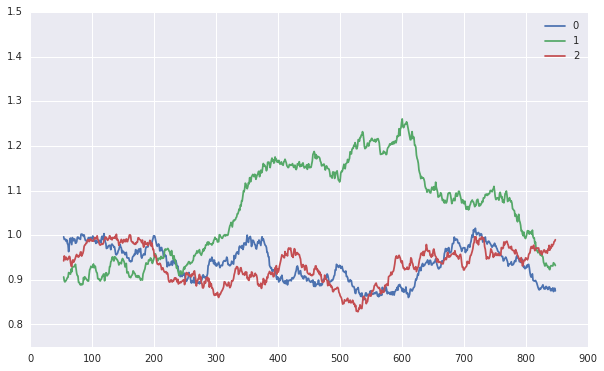

In [361]:
# ompA
seq = 'CCGTCACCAACGACAAAATTTGCGAGGCTCTTTCCGAAAATAGGGTTGATCTTTGTTGTCACTGGATGTACTGTACATCCATACAGTAACTCACAGGGGCTGGATTGATTATGTACACTTCAGGCTATGCACATCGTTCTTCGTCGTTCTCATCCGCAGCAAGTAAAATTGCGCGTGTCTCTACGGAAAACACTACAGCCGGGCTTATCAGTGAAGTTGTCTATCGCGAAGATCAGCCCATGATGACGCAACTTCTACTGTTGCCATTGTTACAGCAACTCGGTCAGCAATCGCGCTGGCAACTCTGGTTAACACCGCAACAAAAACTGAGTCGGGAATGGGTTCAGGCATCTGGGCTACCCTTAACGAAAGTAATGCAGATTAGCCAGCTCTCCCCTTGCCACACTGTGGAGTCAATGGTTCGCGCTTTACGCACGGGCAATTACAGTGTGGTGATCGGTTGGTTGGCAGATGATTTGACTGAAGAAGAGCATGCTGAACTTGTTGATGCGGCAAATGAAGGTAACGCTATGGGGTTTATTATGCGTCCGGTAAGCGCATCCTCTCACGCCACGAGACAACTTTCCGGGCTAAAAATTCACTCTAATTTGTATCATTAAGTAAATTTAGGATTAATCCTGGAACTTTTTTTGTCGCCCAGCCAATGCTTTCAGTCGTGACTAATTTTCCTTGCGGAGGCTTGTCTGAAGCGGTTTCCGCGATTCTCTTCTGTAAATTGTCGCTGACAAAAAAGATTAAACATACCTTATACAAGACTTTTTTTTCATATGCCTGACGGAGTTCACACTTGTAAGTTTTCAACTACGTTGTAGACTTTACATCGCCAGGGGTGCTCGGCATAAGCCGAAGATATCGGTAGAGTTAATATTGAGCAGATCCCCCGGTGAAGGATTTAACCGTGTTATCTCGTTGGAGATATTCATGGCGTATTTTGGATGATAACGAGGCGCAAAAAATGAAAAAGACAGCTATCGCGATTGCAGTGGCACTGGCTGGTTTCGCTACCGTAGCGCAGGCCGCTCCGAAAGATAACACCTGGTACACTGGTGCTAAACTGGGCTGGTCCCAGTACCATGACACTGGTTTCATCAACAACAATGGCCCGACCCATGAAAACCAACTGGGCGCTGGTGCTTTTGGTGGTTACCAGGTTAACCCGTATGTTGGCTTTGAAATGGGTTACGACTGGTTAGGTCGTATGCCGTACAAAGGCAGCGTTGAAAACGGTGCATACAAAGCTCAGGGCGTTCAACTGACCGCTAAACTGGGTTACCCAATCACTGACGACCTGGACATCTACACTCGTCTGGGTGGCATGGTATGGCGTGCAGACACTAAATCCAACGTTTATGGTAAAAACCACGACACCGGCGTTTCTCCGGTCTTCGCTGGCGGTGTTGAGTACGCGATCACTCCTGAAATCGCTACCCGTCTGGAATACCAGTGGACCAACAACATCGGTGACGCACACACCATCGGCACTCGTCCGGACAACGGCATGCTGAGCCTGGGTGTTTCCTACCGTTTCGGTCAGGGCGAAGCAGCTCCAGTAGTTGCTCCGGCTCCAGCTCCGGCACCGGAAGTACAGACCAAGCACTTCACTCTGAAGTCTGACGTTCTGTTCAACTTCAACAAAGCAACCCTGAAACCGGAAGGTCAGGCTGCTCTGGATCAGCTGTACAGCCAGCTGAGCAACCTGGATCCGAAAGACGGTTCCGTAGTTGTTCTGGGTTACACCGACCGCATCGGTTCTGACGCTTACAACCAGGGTCTGTCCGAGCGCCGTGCTCAGTCTGTTGTTGATTACCTGATCTCCAAAGGTATCCCGGCAGACAAGATCTCCGCACGTGGTATGGGCGAATCCAACCCGGTTACTGGCAACACCTGTGACAACGTGAAACAGCGTGCTGCACTGATCGACTGCCTGGCTCCGGATCGTCGCGTAGAGATCGAAGTTAAAGGTATCAAAGACGTTGTAACTCAGCCGCAGGCTTAAGTTCTCGTCTGGTAGAAAAACCCCGCTGCTGCGGGGTTTTTTTTGCCTTTAGTAAATTGAACTGACTTTCGTCAGTTATTCCTTACCCAGCAATGCCTGCAGATCCTGCTTCAGAGAAGACATTTTATTCGCGTATTTCTCTTTGTTTTCCGCATCTTCAATCAGCTGAACAATCGTTTCAGAAAGCGTTTTACCGCGACGCTGCGCAAGACCAGCCAGACGTTGCCAGACAATAAATTCCAGATCGATCGATTTTTTGCGCGTATGCTGGTGTTCCGCATTAAAATGGCGCTTTCGTCTTGCCCGAATGGTTTGCTTCATGCGATTGACCAGTTCCGGATTCATATGCTTGTCAATCCAGCCATTTACCAGCACGGGTTCATTTTCCAGCGAGAGCAACACATCGACGGCTTCCTGGGCGGCACTGGCTTCTATGTAACGGGTGATTAACTCCCCTTCGCGATGCTTCTTAACCAGATACTTCCATTTCCAACCGCTTTCAAGATTTTCAAGTTGTTGATATTTCATAGCGATCTCAATGTTACCGTGTAACTCTTTACAGAATATCAGCTTTTTAGGCCAGTGAAGAAAAGAATCTCCATCCTGTGAGCTTTAACGCCCATGCCAGGAGTATTGTCGGTGCTTTCTACGTGTGCTGTAGTGCCGGTTACGGTATAATCGCGGCTTTG'

scores = codonPrefs(seq,round(len(seq)/25))
scores.plot(kind='line',subplots=False,figsize=(10,6),ylim=[.75,1.5])